##Importing modules

In [1]:
!pip install spacy nltk beautifulsoup4
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
df = pd.read_csv("category_wikipedia_articles.csv")
df.head()


,Title,Content,Category
0,Mathematics,Mathematics is a field of study that discovers...,Mathematics
1,Beijing Institute of Mathematical Sciences and...,Beijing Institute of Mathematical Sciences and...,Mathematics
2,Language of mathematics,The language of mathematics or mathematical la...,Mathematics
3,Law (mathematics),"In mathematics, a law is a formula that is alw...",Mathematics
4,Glossary of areas of mathematics,Mathematics is a broad subject that is commonl...,Fields of mathematics


In [6]:
class DataPreprocessing:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')

        self.category_mapping = {
            'Fields of mathematics': 'Mathematics',
            'Mathematics-related lists': 'Mathematics',
            'Branches of biology': 'Biology',
            'Organisms': 'Biology',
            'Biologists': 'Biology',
            'Biology-related lists': 'Biology',
            'Geographers': 'Geography',
            'Geography-related lists': 'Geography',
            'History by ethnic group': 'History',
            'History by period': 'History',
            'Fields of history': 'History',
            'Historiography': 'History',
            'Branches of science': 'Science',
            'Scientific disciplines': 'Science',
            'Scientists': 'Science',
            'Science in society': 'Science'
        }
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'\w+')

    def map_categories(self, df):
        #Replacing categories in the DataFrame using the mapping.
        df['Category'] = df['Category'].replace(self.category_mapping)
        return df

    def remove_stop_words(self, text):
        #Removing stop words from the file.
        text = text.lower()
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)

    def process_content(self, df):
        #Removes stop words from column content.
        df['Content'] = df['Content'].apply(self.remove_stop_words)
        return df

    def metadata_fix(self, text):
        #Cleaning HTML tags and unwanted characters from the content column.
        soup = BeautifulSoup(text, "html.parser")
        cleaned_text = soup.get_text()
        cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
        return cleaned_text

    def fix_metadata(self, df):
        #Applying metadata cleaning to the Content column.
        df['Content'] = df['Content'].apply(self.metadata_fix)
        return df

    def lemmatize_words(self, text):
        #Lemmatizing words in the content column.
        words = word_tokenize(text)
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    def lemmatize_content(self, df):
        #Applying lemmatization to the Content column
        df['Content'] = df['Content'].apply(self.lemmatize_words)
        return df

    def tokenize_content_spacy(self, df):
        #Tokenize content using spaCy.
        df['Content'] = df['Content'].apply(lambda x: [token.text for token in self.nlp(x)])
        return df

In [8]:
data_preprocessor = DataPreprocessing()


df = data_preprocessor.map_categories(df)     # Step 1: Map categories
df = data_preprocessor.fix_metadata(df)        # Step 2: Fix metadata
df = data_preprocessor.process_content(df)     # Step 3: Remove stop words
df = data_preprocessor.lemmatize_content(df)   # Step 4: Lemmatize content
df = data_preprocessor.tokenize_content_spacy(df)

##Testing Model

In [9]:
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'RandomForest': RandomForestClassifier()
}

params = {
    'MultinomialNB': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'min_samples_split': [2, 5]
    }
}



In [10]:
df['Content'] = df['Content'].apply(lambda x: ' '.join(x))
best_estimators = {}
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Category'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

for model_name in models:
    print(f"\nTraining {model_name}...")
    model = models[model_name]
    param_grid = params[model_name]

    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

    best_estimators[model_name] = grid_search.best_estimator_




Training MultinomialNB...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for MultinomialNB: {'alpha': 1.0}
Best cross-validation score for MultinomialNB: 0.905

Training LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for LogisticRegression: {'C': 10, 'solver': 'liblinear'}
Best cross-validation score for LogisticRegression: 0.915

Training SVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for SVC: {'C': 10, 'kernel': 'linear'}
Best cross-validation score for SVC: 0.8949999999999999

Training RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for RandomForest: {'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score for RandomForest: 0.8775000000000001


##Model Evaluation


Classification Report for LogisticRegression:

              precision    recall  f1-score   support

     Biology       1.00      1.00      1.00        14
   Geography       0.82      0.90      0.86        10
     History       1.00      0.88      0.93        24
 Mathematics       0.97      1.00      0.98        28
     Science       0.96      1.00      0.98        24

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100



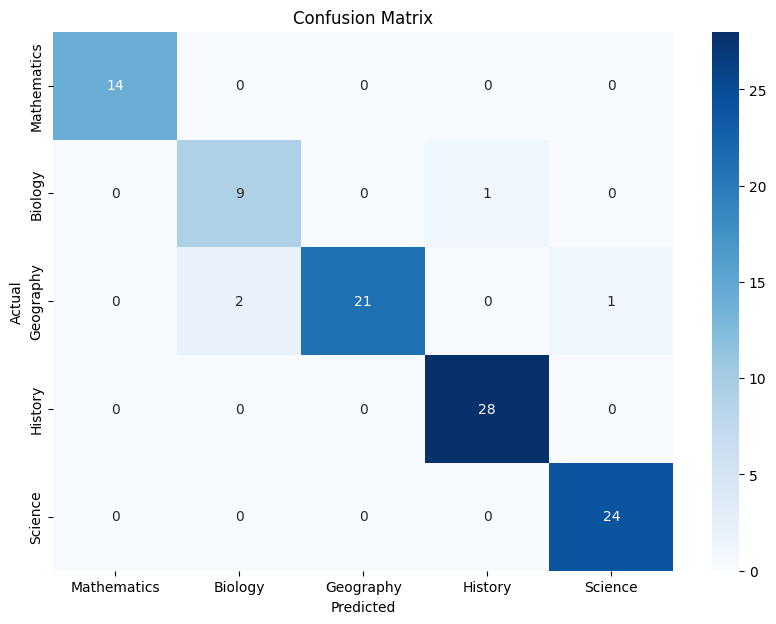

In [11]:
best_model_name = max(best_estimators, key=lambda k: best_estimators[k].score(X_test, y_test))
best_model = best_estimators[best_model_name]
y_pred = best_model.predict(X_test)


print(f"\nClassification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['Category'].unique(), yticklabels=df['Category'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
